# Testing Coincidence using a Na-22 Source

## Introduction

### Coincidence Filtering of Sodium-22 (Na-22)

Sodium 22 (Na-22) is a radioactive isotope with one less neutron than the \"stable\" form of Sodium 23. With a half life of 2.60 years, it\'s a relatively shelf stable isotype making it conveinent in labs as a calibration. 

In most cases, the Na-22 emits a positron and decays into an excited Ne-22 nucleus. The Ne-22 nucleus then falls to ground state and emits of *1.2745 MeV* gamma ray. 


![alt text](data/na22_images/equation.png "Nuclear Reaction")

After this initial nuclear decay, the emitted positron generally annilihates with an electron and that reactions emits a pair of *.511 MeV* gamma rays. Importantly, these annhilitation gamma rays are emitted in opposite directions. 

![alt text](data/na22_images/equation2.png "Positron Annhilation")

Taking advantage of this, we can set up detectors opposite of each other on either side of our Na-22 source and selectively save primarily annihilation events using the FemtoDAQ Vireo's coincidence filter. 

![alt text](data/na22_images/setup.png "Coincidence Setup")

### Experimental Setup

The Vireo's **coincidence filter** allows you to selectively trigger on events which create a certain hit pattern on your detectors. In the case of *Na-22*, we want to only measure events which create pulses on our two detectors simultaneously. This will screen out the vast majority of noise events caused by _Ne-22*_ excitation or ambient noises such as cosmic rays. These noise sources are statistically unlikely to interact with two detectors simultaneously. Unlike the annhiliation decay which emits two opposing gamma rays perfectly in line with our detectors.  

![alt text](data/na22_images/pic_of_setup.jpeg "Picture of Setup")



## **In this experiment we will:**

### 1) **Collect data using 2-hit coincidence** to show detection of only the .511 MeV beta decay peak
### 2) **Collect data without coincidence** to show detection of all sodium lines - including the 1.2745 MeV Ne-22 excitation peak

___
___

## **Collecting Data**

### Setting up Environment

We're going to define some variables up front so they are easier to change later. `TRIGGER_SENSITIVITY` defines how sensitive the trigger is to capture a pulse. `NUMBER_OF_EVENTS` indicates how many events we are going to capture before stopping data collection

In [1]:
import skutils
import math
import numpy as np
import matplotlib.pyplot as plt

VIREO_URL = "vireo-000019.tek" 
TRIGGER_SENSITIVITY = 40
NUMBER_OF_EVENTS = 100_000


Skutils is in beta, please contact support@skutek.com with bugs, issues, and questions


### **1) Connect to your FemtoDAQ Vireo**

We can use the `FemtoDAQController` class to control our digitizer remotely in this python script. The FemtoDAQ Controller contains functions to control trigger, data capture, and recording configuration. We will use it here to configure our trigger parameters.

In [2]:
vireo = skutils.FemtoDAQController(VIREO_URL, skip_version_check=True)
print( vireo.summary() )

Vireo-000019 (http://vireo-000019.tek)
Product Revision    : VIREO100_REV_B
Number of Channels  : 2
Sampling Frequency  : 100.0 MHz
ADC Bitdepth        : 14 bits
Maximum Wave Length : 81.92us
Firmware Version    : 5.5.0-0
Software Version    : 5.4.0
Linux Image Version : 5.1.1


### **2) Configure Data Recording Parameters**

Before capturing data, we need to configure the instrument to trigger at the appropriate levels.

In [3]:
# Configuring Trigger Settings
vireo.setTriggerSensitivity(0, TRIGGER_SENSITIVITY)
vireo.setTriggerSensitivity(1, TRIGGER_SENSITIVITY)
vireo.setTriggerXPosition(128)
vireo.setInvertADCSignal(0, True)
vireo.setInvertADCSignal(1, True)
vireo.setDigitalOffset(0, 640)
vireo.setDigitalOffset(1, 640)

# Enabling Triggers 
vireo.setEnableTrigger(0, True)
vireo.setEnableTrigger(1, True)

# Configuring Pulse Windows
vireo.setPulseHeightAveragingWindow(8)
vireo.setTriggerActiveWindow(32)
vireo.setPulseHeightWindow(32)

-----

### **3) Collect Coincidence data**
#### i) **Set Coincidence**: Require at Least 2 Triggers for Saved Events

In [4]:
# Configuring Coincidence
vireo.configureCoincidence("multiplicity",  2)

#### ii) **Recording**: Name files with appropriate prefix and define our file format

In [5]:
# Configure Recording on CH0, CH1
vireo.configureRecording(channels_to_record=[0,1],
                            file_recording_name_prefix = "Na-22_with_coincidence",
                            file_recording_format = "igorph",
                        )

#### iii) **Start Data Collection**: Wait until complete or a maximum timeout is reached

In [6]:
vireo.start(NUMBER_OF_EVENTS)
# Wait for data to be collected up to a maximum of 20 minutes
timed_out = vireo.waitUntil(timeout_time=20*60)
vireo.stop()

#### iiii) **Download Data Files** for later analysis

In [7]:
coincidence_data_files = vireo.downloadLastRunDataFiles()

Vireo-000019 (http://vireo-000019.tek) Controller : downloaded `Na-22_with_coincidence_03.45.26PM_May16_2025_seq000001.itx` to 'C:\Users\Jeff\Documents\projects\skutils\docs\examples\Na-22_with_coincidence_03.45.26PM_May16_2025_seq000001.itx'


-----

### **4) Collect No-Coincidence data**
#### i) **Set No Coincidence**: Disable coincidence by setting a multiplicity of 1

In [8]:
# Configuring Coincidence
vireo.configureCoincidence("multiplicity",  1)

#### ii) **Recording**: Name files with appropriate prefix and define our file format

In [9]:
# Configure Recording on CH0, CH1
vireo.configureRecording(channels_to_record=[0,1],
                            file_recording_name_prefix = "Na-22_with_no_coincidence",
                            file_recording_format = "igorph",
                        )

#### iii) **Start Data Collection**: Wait until complete or a maximum timeout is reached

In [10]:
vireo.start(NUMBER_OF_EVENTS)
# Wait for data to be collected up to a maximum of 20 minutes
timed_out = vireo.waitUntil(timeout_time=20*60)
vireo.stop()

#### iiii) **Download Data Files** for later analysis

In [11]:
no_coincidence_data_files = vireo.downloadLastRunDataFiles()

Vireo-000019 (http://vireo-000019.tek) Controller : downloaded `Na-22_with_no_coincidence_04.05.28PM_May16_2025_seq000001.itx` to 'C:\Users\Jeff\Documents\projects\skutils\docs\examples\Na-22_with_no_coincidence_04.05.28PM_May16_2025_seq000001.itx'


_____
_____

## Data Analysis

### **5) Loading Data**: Grab Pulse Heights for every Event

In [12]:
# loading in coincidence data
ch0_coincidence_pulse_heights = []
ch1_coincidence_pulse_heights = []
for event in skutils.quickLoad(coincidence_data_files):
    ch0_coincidence_pulse_heights.append(event.pulse_heights[0])
    ch1_coincidence_pulse_heights.append(event.pulse_heights[1])


# loading in no coincidence data
ch0_no_coincidence_pulse_heights = []
ch1_no_coincidence_pulse_heights = []
for event in skutils.quickLoad(no_coincidence_data_files):
    ch0_no_coincidence_pulse_heights.append(event.pulse_heights[0])
    ch1_no_coincidence_pulse_heights.append(event.pulse_heights[1])


### **6) Histogramming**: Calculate a Pulse Height Histogram

Pulse Heights here refer to the DSP Pulse Height quantity calculated in firmware, which is subject to filtering/averaging 
and configured in your data collection setup. 

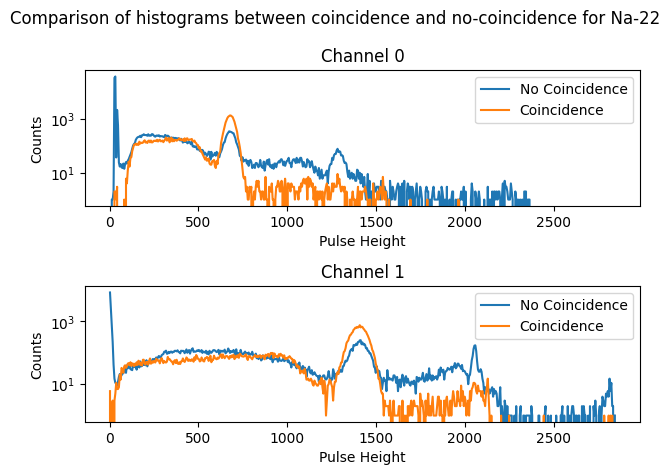

In [45]:
bin_width = 5
num_bins = int((x_max - x_min) / bin_width)

coincidence_hist0, edges = np.histogram(ch0_coincidence_pulse_heights, bins=num_bins, range=(0, x_max))
coincidence_hist1, _     = np.histogram(ch1_coincidence_pulse_heights, bins=num_bins, range=(0, x_max))
no_coincidence_hist0, _  = np.histogram(ch0_no_coincidence_pulse_heights, bins=num_bins, range=(0, x_max))
no_coincidence_hist1, _  = np.histogram(ch1_no_coincidence_pulse_heights, bins=num_bins, range=(0, x_max))

bin_centers = (edges[1:] + edges[:-1]) / 2

fig,axes = plt.subplots(2,1)
fig.suptitle("Comparison of histograms between coincidence and no-coincidence for Na-22")
axes[0].set_title("Channel 0")
axes[0].set_xlabel("Pulse Height")
axes[0].set_ylabel("Counts")
axes[0].set_yscale('log')
axes[0].plot(bin_centers,no_coincidence_hist0, label="No Coincidence")
axes[0].plot(bin_centers,coincidence_hist0,    label="Coincidence")
axes[0].legend()

axes[1].set_title("Channel 1")
axes[1].set_xlabel("Pulse Height")
axes[1].set_yscale('log')
axes[1].set_ylabel("Counts")
axes[1].plot(bin_centers,no_coincidence_hist1, label="No Coincidence")
axes[1].plot(bin_centers,coincidence_hist1,    label="Coincidence")
axes[1].legend()

fig.tight_layout()
plt.show()

## Summary

We can see the obvious difference between coincidence (orange) and no-coincidence (blue) histograms. No-Coincidence has a much more prominent noise peak near bin0. Without coincidence suppression, pulse heights are saved for all channels whether or the channel triggered. This results in large "noise" peaks more or less equal to the channel baseline. 

Coincidence histograms also notably only have 1 major signal peak - the 0.511MeV line beta decay line produced by positron and which creates a pair of photons. No-Coincidence histograms see a secondary peak produced by the single photon released by Ne*-22 excitation.